In [1]:
from typing import Callable, Dict, List, Tuple
import jax
import jax.numpy as jnp
from jax.tree_util import register_pytree_node_class
from functools import partial
import numpy as np
import time
import cv2
from pathlib import Path
import imgui
import moderngl
from pyrr import Matrix44
import moderngl_window as mglw
from moderngl_window import geometry
from moderngl_window.integrations.imgui import ModernglWindowRenderer
import PIL
from scipy.spatial import Delaunay


@register_pytree_node_class
class Gaussian:
    def __init__(self, eta, Lam):
        self.eta = eta
        self.Lam = Lam

    def tree_flatten(self):
        return (self.eta, self.Lam), None

    @classmethod
    def tree_unflatten(cls, aux_data, children):
        return cls(*children)

    def mu(self):
        return jnp.where(
            jnp.allclose(self.Lam, 0), self.eta, jnp.linalg.solve(self.Lam, self.eta)
        )
    
    def sigma(self):
        return jnp.linalg.inv(self.Lam)

    def zero_like(self):
        return Gaussian(jnp.zeros_like(self.eta), jnp.zeros_like(self.Lam))

    def __repr__(self) -> str:
        return f"Gaussian(eta={self.eta}, lam={self.Lam})"

    def __mul__(self, other):
        return Gaussian(self.eta + other.eta, self.Lam + other.Lam)

    def __truediv__(self, other):
        return Gaussian(self.eta - other.eta, self.Lam - other.Lam)

    def copy(self):
        return Gaussian(self.eta.copy(), self.Lam.copy())


@register_pytree_node_class
class Variable:
    var_id: int
    belief: Gaussian
    msgs: Gaussian
    adj_factor_idx: jnp.array

    def __init__(self, var_id, belief, msgs, adj_factor_idx):
        self.var_id = var_id
        self.belief = belief
        self.msgs = msgs
        self.adj_factor_idx = adj_factor_idx

    def tree_flatten(self):
        return (self.var_id, self.belief, self.msgs, self.adj_factor_idx), None

    @classmethod
    def tree_unflatten(cls, aux_data, children):
        return cls(*children)


@register_pytree_node_class
class Factor:
    factor_id: jnp.array
    z: jnp.ndarray
    z_Lam: jnp.ndarray
    threshold: jnp.ndarray
    potential: Gaussian
    adj_var_id: jnp.array
    adj_var_idx: jnp.array

    def __init__(
        self, factor_id, z, z_Lam, threshold, potential, adj_var_id, adj_var_idx
    ):
        self.factor_id = factor_id
        self.z = z
        self.z_Lam = z_Lam
        self.threshold = threshold
        self.potential = potential
        self.adj_var_id = adj_var_id
        self.adj_var_idx = adj_var_idx

    def tree_flatten(self):
        return (
            self.factor_id,
            self.z,
            self.z_Lam,
            self.threshold,
            self.potential,
            self.adj_var_id,
            self.adj_var_idx,
        ), None

    @classmethod
    def tree_unflatten(cls, aux_data, children):
        return cls(*children)


@partial(jax.jit, static_argnames=["i", "j"])
def marginalize(gaussians: Gaussian, i, j): # Equ. (46), (47); Compute msg to i:j Variables from connected factors
    eta = gaussians.eta
    Lam = gaussians.Lam
    k = eta.size
    idx = jnp.arange(0, k)
    aa = idx[i:j] # index from i to j-1
    bb = jnp.concat([idx[:i], idx[j:]]) # rest
    aa_eta = eta[aa]
    bb_eta = eta[bb]
    aa_Lam = Lam[aa[:, None], aa]
    ab_Lam = Lam[aa[:, None], bb]
    bb_Lam = Lam[bb][:, bb]
    if bb_Lam.size == 0:
        return Gaussian(aa_eta, aa_Lam)
    # print("How large? ", bb_Lam.shape)

    bb_Cov = jnp.linalg.inv(bb_Lam)
    eta = aa_eta - ab_Lam @ bb_Cov @ bb_eta
    Lam = aa_Lam - ab_Lam @ bb_Cov @ ab_Lam.T
    return Gaussian(eta, Lam)


def tree_stack(tree, axis=0, use_np=True):
    if use_np:
        return jax.tree.map(lambda *v: jnp.array(np.stack(v, axis=axis)), *tree)
    return jax.tree.map(lambda *v: jnp.stack(v, axis=axis), *tree)


def h_fn(x):
    return x


def h2_fn(xs):
    """
    xs: shape (2, D), where:
        - xs[0] is x1
        - xs[1] is x2
    """
    x1 = xs[0]
    x2 = xs[1]
    return x2 - x1


# @jax.jit
def update_belief(var: Variable, ftov_msgs): # Calculate Eq. (7)
    belief = var.belief.zero_like()
    for i in range(ftov_msgs.eta.shape[0]):
        belief = belief * Gaussian(ftov_msgs.eta[i], ftov_msgs.Lam[i])


    return belief

"""
# @jax.jit
def update_belief(varis: Variable, ftov_msgs):
    belief = varis.belief.zero_like()

    mask = (varis.adj_factor_idx >= 0)[..., None]

    # Debug: print mask
    jax.debug.print("mask = {}", mask)

    varis.msgs.eta = varis.msgs.eta * mask
    varis.msgs.Lam = varis.msgs.Lam * mask[..., None]

    # Debug: print masked eta
    jax.debug.print("masked msgs.eta = {}", varis.msgs.eta)

    for i in range(ftov_msgs.eta.shape[0]):
        msg = Gaussian(ftov_msgs.eta[i], ftov_msgs.Lam[i])
        belief = belief * msg

    return belief
"""


# @jax.jit
def compute_vtof_msgs(var: Variable, ftov_msgs): # Eq.(19); do for each variable (x_m)
    vtof_msgs = []
    for i, idx in enumerate(var.adj_factor_idx): # for each f_si connected to x_m...
        msg = var.belief / Gaussian(ftov_msgs.eta[i], ftov_msgs.Lam[i]) # Eq.(19) LHS subscript of SUM
        eta = jnp.where(idx < 0, msg.zero_like().eta, msg.eta) # Those not connected should not affect the calculation (idx < 0)
        Lam = jnp.where(idx < 0, msg.zero_like().Lam, msg.Lam) # The reason to not using "if" (while it's per-element) is to optimize better
        vtof_msgs.append(Gaussian(eta, Lam)) # append (x_m -> f_si)
    return tree_stack(vtof_msgs, use_np=False) # [(x_m -> f_s1), (x_m -> f_s2), ... ] # The length is Ni_v


@partial(jax.jit, static_argnames=["h_fn"])
def factor_energy(factor, xs, h_fn):
    h = h_fn(xs)
    z = factor.z
    z_Lam = factor.z_Lam
    r = z - h
    return 0.5 * r @ z_Lam @ r.T



# @partial(jax.jit, static_argnames=["h_fn", "w"])
def factor_update(factor, xs, h_fn, w):
    h = h_fn(xs)
    J = jax.jacrev(h_fn)(xs).reshape(h.size, xs.size) # Jacobian auto-diff (J_s)
    z = factor.z # I think this is a vector
    z_Lam = factor.z_Lam
    r = z - h.reshape(-1) # TODO: reshape can be problematic
    s = w(r.T @ z_Lam @ r, factor.threshold) # Scale to consider Robust Loss
    Lam = s * J.T @ z_Lam @ J # Eq. (36)
    eta = s * J.T @ z_Lam @ (J @ xs.reshape(-1) + r) # TODO: reshape can be problematic; Eq. (36); xs should be a vector
    return Gaussian(eta, Lam) # Factor; represented w.r.t. neighboring variables xs


# @jax.jit
def compute_ftov_msg(factor, vtof_msgs): # Ch 3.5 Message Passing at a Factor Node
    N_adj, dim = vtof_msgs.eta.shape # #Ni_v * 3 (#Varis is vmapped)
    pot = factor.potential.copy() # log(f_s), but for only a specific variable a factor is connected to.
    i = 0
    for n in range(N_adj): # Add all! (Produce all)
        j = i + dim
        pot.eta = pot.eta.at[i:j].add(vtof_msgs.eta[n])
        pot.Lam = pot.Lam.at[i:j, i:j].add(vtof_msgs.Lam[n])
        i = j


    ftov_msgs = []
    i = 0
    for n in range(N_adj):
        j = i + dim
        pot_m_1 = pot.copy()
        pot_m_1.eta = pot_m_1.eta.at[i:j].add(-vtof_msgs.eta[n]) # Subtract direction of going out! (42)
        pot_m_1.Lam = pot_m_1.Lam.at[i:j, i:j].add(-vtof_msgs.Lam[n]) # (43)
        msg = marginalize(pot_m_1, i, j) # (46), (47)
        ftov_msgs.append(msg)
        i = j
    return tree_stack(ftov_msgs, use_np=False)


@jax.jit
def update_variable(varis): # Update belief with receiving msgs and calculate msg to factors; varis.msgs are up-to-date and varis.belief are not
    varis.belief = jax.vmap(update_belief)(varis, varis.msgs) # Eq. (7); varis.msgs is receiving msgs (ftov)
    vtof_msgs = jax.vmap(compute_vtof_msgs)(varis, varis.msgs) # Variable -> Factor Msg; Eq. (19)
    linpoints = jax.vmap(lambda x: x.mu())(varis.belief) # Current avg of belief! Belief is posterior

    return varis, vtof_msgs, linpoints # vtof msgs: # Var * # Var-direction (factor, Ni_v) msgs


@partial(jax.jit, static_argnames=["f", "w"])
def update_factor(facs, varis, vtof_msgs, linpoints, f, w): # f is factor function, w is robustifier
    vtof_msgs_reordered = jax.tree_util.tree_map( # Variable to factor messages to specific (variable, factor; or variable-direction) pair
        lambda x: x[facs.adj_var_id, facs.adj_var_idx], vtof_msgs # id: Variable id (one end), idx: direction (another end)
    )
    linpoints_reordered = jax.tree_util.tree_map(
        lambda x: x[facs.adj_var_id], linpoints # Reorder linpoints by adj_var_id: variables' mean for factors' one ends
    )
    
    facs.potential = jax.vmap(factor_update, in_axes=(0, 0, None, None))( # Calculate each factor potential (f_s(x, x_1, ..., x_M) of Eq. (15))
        facs, linpoints_reordered, f, w # Each factor contribution of variable-direction pair (factor: variable-direction pair)
    ) # 1 or 2-dimensional!! (gradient / prior factor or smoothness factor)
    ftov_msgs = jax.vmap(compute_ftov_msg)(facs, vtof_msgs_reordered) # ftov calculation by Eq. (15), with potential f_s, and msg vtof
    varis.msgs.eta = varis.msgs.eta.at[facs.adj_var_id, facs.adj_var_idx].set( # Setting varis' receiving messages
        ftov_msgs.eta
    )
    varis.msgs.Lam = varis.msgs.Lam.at[facs.adj_var_id, facs.adj_var_idx].set(
        ftov_msgs.Lam
    )

    mask = (varis.adj_factor_idx >= 0)[..., None]
    varis.msgs.eta = varis.msgs.eta * mask
    varis.msgs.Lam = varis.msgs.Lam * mask[..., None]

    return facs, varis


@jax.jit
def huber(e, t):
    x = jnp.sqrt(e)
    return jnp.where(x <= t, 1.0, t / x)


@jax.jit
def l2(e, _):
    return 1.0

In [2]:
def build_pose_slam_graph(N, prior_meas, between_meas, noise_std, Ni_v=15, D=2):
    """
    Build a 2D pose-SLAM factor graph with:
    - N variable nodes (each 2D position)
    - Prior measurements (with strong precision)
    - Between measurements (with moderate precision from noise_std)
    
    Parameters:
    - N: number of variables
    - prior_meas: list of (i, z) where z is the prior measurement at node i
    - between_meas: list of (i, j, z) where z is relative measurement from i to j
    - noise_std: standard deviation for between measurements (list or array of length D)
    - Ni_v: number of factor connections per variable (default 15)
    - D: dimension of each variable (default 2)
    
    Returns:
    - varis: Variable object
    - prior_facs: Factor object for priors
    - between_facs: Factor object for between factors
    """

    # === Step 1: Initialize Variable nodes ===
    var_ids = jnp.arange(N, dtype=jnp.int32)
    belief = Gaussian(jnp.zeros((N, D)), jnp.tile(jnp.eye(D), (N, 1, 1)))  # initial mean 0, covariance I
    msgs = Gaussian(jnp.zeros((N, Ni_v, D)), jnp.zeros((N, Ni_v, D, D)))  # messages (eta, Lambda) to each factor port
    adj_factor_idx = -jnp.ones((N, Ni_v), dtype=jnp.int32)  # -1 indicates no connected factor at this port

    varis = Variable(var_ids, belief, msgs, adj_factor_idx)

    # === Step 2: Build Prior Factors (strong precision for anchoring the graph) ===
    prior_factor_id = []
    prior_z = []
    prior_z_Lam = []
    prior_threshold = []
    prior_adj_var_id = []
    prior_adj_var_idx = []

    fac_counter = 0  # global factor ID counter

    for (i, z) in prior_meas:
        prior_factor_id.append(fac_counter)
        prior_z.append(jnp.array(z))

        # Very strong prior: small noise variance -> large precision
        strong_prior_std = 1e-7
        prior_z_Lam.append(jnp.eye(D) / strong_prior_std)  # shape (D, D)

        prior_threshold.append(1.0)
        prior_adj_var_id.append([i])     # only connected to variable i
        prior_adj_var_idx.append([0])     # use port 0 for prior

        varis.adj_factor_idx = varis.adj_factor_idx.at[i, 0].set(fac_counter)
        fac_counter += 1

    prior_facs = Factor(
        factor_id=jnp.array(prior_factor_id),
        z=jnp.stack(prior_z),
        z_Lam=jnp.stack(prior_z_Lam),
        threshold=jnp.array(prior_threshold),
        potential=None,
        adj_var_id=jnp.array(prior_adj_var_id),
        adj_var_idx=jnp.array(prior_adj_var_idx),
    )

    # === Step 3: Build Between Factors (relative pose measurements) ===
    between_factor_id = []
    between_z = []
    between_z_Lam = []
    between_threshold = []
    between_adj_var_id = []
    between_adj_var_idx = []

    for (i, j, z) in between_meas:
        between_factor_id.append(fac_counter)
        between_z.append(jnp.array(z))

        # Between-factor noise: use provided noise_std to compute precision
        between_z_Lam.append(jnp.diag(1.0 / (jnp.array(noise_std) )))  # shape (D, D)

        between_threshold.append(1.0)

        # Assign first empty port >=1 to variable i and j
        port_i = int(jnp.argmax(varis.adj_factor_idx[i, 1:] == -1)) + 1
        port_j = int(jnp.argmax(varis.adj_factor_idx[j, 1:] == -1)) + 1
        varis.adj_factor_idx = varis.adj_factor_idx.at[i, port_i].set(fac_counter)
        varis.adj_factor_idx = varis.adj_factor_idx.at[j, port_j].set(fac_counter)

        between_adj_var_id.append([i, j])
        between_adj_var_idx.append([port_i, port_j])
        fac_counter += 1

    between_facs = Factor(
        factor_id=jnp.array(between_factor_id),
        z=jnp.stack(between_z),
        z_Lam=jnp.stack(between_z_Lam),
        threshold=jnp.array(between_threshold),
        potential=None,
        adj_var_id=jnp.array(between_adj_var_id),
        adj_var_idx=jnp.array(between_adj_var_idx),
    )

    return varis, prior_facs, between_facs


In [3]:
def generate_loopy_pose_slam_data(N=50, seed=0, odom_noise_std=0.5):
    np.random.seed(seed)
    positions = np.random.rand(N, 2) * 100  # True Location

    tri = Delaunay(positions)
    edges = set()
    for triangle in tri.simplices:
        for i in range(3):
            a, b = triangle[i], triangle[(i + 1) % 3]
            edges.add(tuple(sorted((a, b))))
    edges = list(edges)

    prior_meas = [(0, positions[0].tolist())]  # fix anchor node

    between_meas = []
    for (i, j) in edges:
        rel = positions[j] - positions[i]
        noise = np.random.randn(2) * odom_noise_std
        rel_noisy = (rel + noise).tolist()
        between_meas.append((i, j, rel_noisy))

    return positions, prior_meas, between_meas, edges


In [4]:
def batch_solve(positions, prior_meas, between_meas, edges, noise_std=1):
    N, D = positions.shape
    dim = N * D
    Lambda = np.zeros((dim, dim))
    eta = np.zeros(dim)

    # set prior measurement
    prior_Lam = np.eye(D) * 1e7
    for (i, z) in prior_meas:
        idx = slice(i * D, (i + 1) * D)
        Lambda[idx, idx] += prior_Lam
        eta[idx] += prior_Lam @ np.array(z)

    # set between measurement
    between_Lam = np.eye(D) / (noise_std)
    for (i, j, z) in between_meas:
        idx_i = slice(i * D, (i + 1) * D)
        idx_j = slice(j * D, (j + 1) * D)
        J_i = -np.eye(D)
        J_j = np.eye(D)

        H_ii = J_i.T @ between_Lam @ J_i
        H_ij = J_i.T @ between_Lam @ J_j
        H_jj = J_j.T @ between_Lam @ J_j
        b_i = J_i.T @ between_Lam @ z
        b_j = J_j.T @ between_Lam @ z

        Lambda[idx_i, idx_i] += H_ii
        Lambda[idx_i, idx_j] += H_ij
        Lambda[idx_j, idx_i] += H_ij.T
        Lambda[idx_j, idx_j] += H_jj
        eta[idx_i] += b_i
        eta[idx_j] += b_j

    x_opt = np.linalg.solve(Lambda, eta)
    return x_opt.reshape(N, D)


In [5]:
def gbp_solve(varis, prior_facs, between_facs, num_iters=50, visualize=False):
    energy_log = []
    
    for i in range(num_iters):
        # Step 1: Variable update
        varis, vtof_msgs, linpoints = update_variable(varis)

        # Step 2: Factor update
        prior_facs, varis = update_factor(prior_facs, varis, vtof_msgs, linpoints, h_fn, l2)
        between_facs, varis = update_factor(between_facs, varis, vtof_msgs, linpoints, h2_fn, l2)


        if visualize:
            # Step 3: Energy computation
            prior_energy = jnp.sum(jax.vmap(factor_energy, in_axes=(0, 0, None))(
                prior_facs, linpoints[prior_facs.adj_var_id[:, 0]], h_fn
            ))
    
            between_energy = jnp.sum(jax.vmap(factor_energy, in_axes=(0, 0, None))(
                between_facs, linpoints[between_facs.adj_var_id], h2_fn
            ))
    
            energy = prior_energy + between_energy
            energy_log.append(energy)
        

    # Step 4: Keep linpoints
    linpoints = jax.vmap(lambda x: x.mu())(varis.belief)  
        
    return varis, prior_facs, between_facs, np.array(energy_log), linpoints


In [8]:
positions, prior_meas, between_meas, edges = generate_loopy_pose_slam_data(
    N=200, seed=42, odom_noise_std=20
)

varis, prior_facs, between_facs = build_pose_slam_graph(
    N=len(positions),
    prior_meas=prior_meas,
    between_meas=between_meas,
    noise_std=[1, 1]
)


cpu_device = jax.devices("cpu")[0]
varis= jax.device_put(varis, cpu_device)
prior_facs = jax.device_put(prior_facs, cpu_device)
between_facs = jax.device_put(between_facs, cpu_device)


print("var_id:", varis.var_id.shape)            # should be (N,)
print("belief.eta:", varis.belief.eta.shape)    # should be (N, D)
print("belief.Lam:", varis.belief.Lam.shape)    # should be (N, D, D)
print("msgs.eta:", varis.msgs.eta.shape)        # should be (N, Ni_v, D)
print("msgs.Lam:", varis.msgs.Lam.shape)        # should be (N, Ni_v, D, D)
print("adj_factor_idx:", varis.adj_factor_idx.shape)  # should be (N, Ni_v)


var_id: (200,)
belief.eta: (200, 2)
belief.Lam: (200, 2, 2)
msgs.eta: (200, 15, 2)
msgs.Lam: (200, 15, 2, 2)
adj_factor_idx: (200, 15)


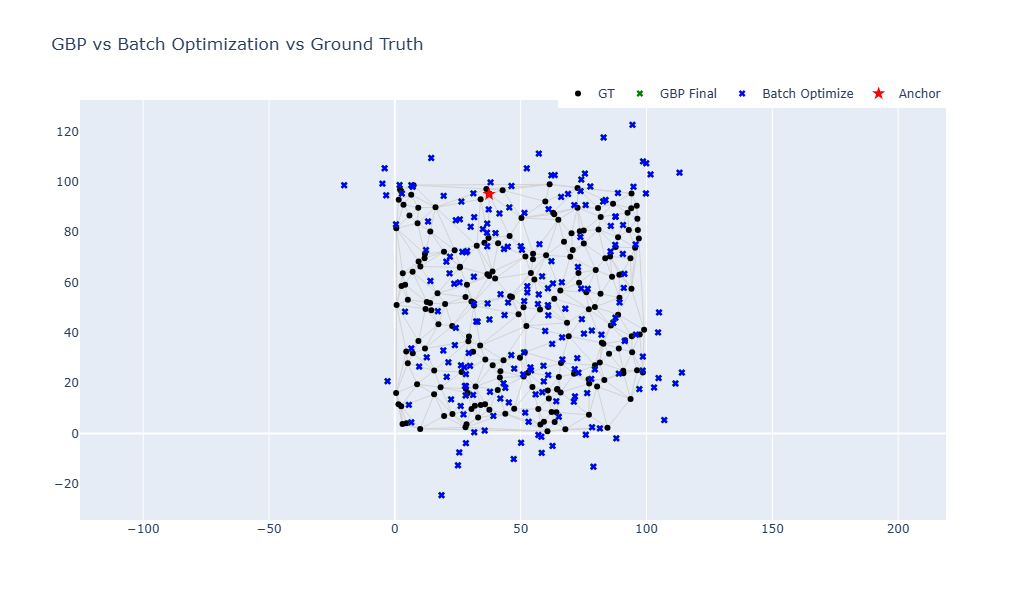

In [11]:
varis, prior_facs, between_facs, energy_log, linpoints = gbp_solve(
    varis, prior_facs, between_facs, num_iters=1000, visualize=True
)
x_opt = batch_solve(positions, prior_meas, between_meas, edges)

import plotly.graph_objects as go
import numpy as np

x_final = linpoints  # GBP final solution after num_iters
fig = go.Figure()

# Edge (gray line)
for (i, j) in edges:
    fig.add_trace(go.Scatter(
        x=[positions[i][0], positions[j][0]],
        y=[positions[i][1], positions[j][1]],
        mode='lines',
        line=dict(color='lightgray', width=1),
        hoverinfo='skip',
        showlegend=False
    ))

# Ground Truth (black dots)
fig.add_trace(go.Scatter(
    x=positions[:, 0], y=positions[:, 1],
    mode='markers', name='GT',
    marker=dict(color='black', size=6, symbol='circle')
))

# GBP final solution (green x)
fig.add_trace(go.Scatter(
    x=x_final[:, 0], y=x_final[:, 1],
    mode='markers', name='GBP Final',
    marker=dict(color='green', size=6, symbol='x')
))

# Batch Optimization solution (blue x)
fig.add_trace(go.Scatter(
    x=x_opt[:, 0], y=x_opt[:, 1],
    mode='markers', name='Batch Optimize',
    marker=dict(color='blue', size=6, symbol='x')
))

# Anchor (red star)
fig.add_trace(go.Scatter(
    x=[positions[0, 0]], y=[positions[0, 1]],
    mode='markers', name='Anchor',
    marker=dict(color='red', size=10, symbol='star')
))

# (Figure settings)
fig.update_layout(
    title='GBP vs Batch Optimization vs Ground Truth',
    xaxis=dict(scaleanchor='y'),
    yaxis=dict(showgrid=False),
    height=600,
    legend=dict(orientation='h', y=1.05, x=1.0, xanchor='right')
)

fig.show()


In [44]:
energy_log

array([5.2206940e+10, 6.3699820e+04, 1.1983283e+05, 1.6747223e+05,
       2.1068144e+05, 1.8772630e+05, 2.1257859e+05, 1.7786314e+05,
       9.2953102e+04, 8.0803875e+04, 5.0280977e+04, 1.7994177e+03,
       1.6036062e+03, 1.5534869e+03, 1.5280464e+03, 1.5147769e+03,
       1.5061483e+03, 1.5002280e+03, 1.4959752e+03, 1.4928365e+03,
       1.4904733e+03, 1.4886613e+03, 1.4872510e+03, 1.4861379e+03,
       1.4852479e+03, 1.4845273e+03, 1.4839371e+03, 1.4834482e+03,
       1.4830387e+03, 1.4826923e+03, 1.4823962e+03, 1.4821407e+03,
       1.4819185e+03, 1.4817230e+03, 1.4815504e+03, 1.4813965e+03,
       1.4812583e+03, 1.4811333e+03, 1.4810201e+03, 1.4809169e+03,
       1.4808223e+03, 1.4807350e+03, 1.4806547e+03, 1.4805803e+03,
       1.4805111e+03, 1.4804467e+03, 1.4803867e+03, 1.4803306e+03,
       1.4802780e+03, 1.4802288e+03, 1.4801825e+03, 1.4801389e+03,
       1.4800980e+03, 1.4800594e+03, 1.4800229e+03, 1.4799886e+03,
       1.4799562e+03, 1.4799253e+03, 1.4798962e+03, 1.4798685e

In [ ]:
cpu_device = jax.devices("cpu")[0]
jax.default_device(cpu_device)

N = 5
D = 2
Ni_v = 3

# Initialize variables
var_ids = np.arange(0, N, dtype=np.int32)
belief = Gaussian(np.zeros((N, D)), np.tile(np.eye(D), (N, 1, 1)))
msgs = Gaussian(np.zeros((N, Ni_v, D)), np.zeros((N, Ni_v, D, D)))
adj_factor_idx = -np.ones((N, Ni_v), dtype=np.int32)
varibles = Variable(var_ids, belief, msgs, adj_factor_idx)

# Set the prior factor(s)
prior_facs = []

z_Lam = np.eye(D)
factor_ids = np.arange(0, 1, dtype=np.int32)
z = np.zeros([1,2])
z_Lams = np.tile(z_Lam * 0.0000001, (1, 1, 1))

threshold = np.ones(1).reshape(-1, 1)
potential = None

adj_var_id = np.arange(0, 1, dtype=np.int32).reshape(-1, 1)
adj_var_idx = np.zeros(1, dtype=np.int32).reshape(-1, 1)
prior_facs = Factor(
    factor_ids, z, z_Lams, threshold, potential, adj_var_id, adj_var_idx
)

# Set the banary factors
factor_ids = [1,2,3,4,5]
between_facs = Factor()


varibles = jax.device_put(varibles, cpu_device)


In [ ]:
A = np.array([[1,-1,0],[0,1,-1],[-1,0,1]])
z = [1,1,1]

